### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Loading the dataset

In [3]:
df = pd.read_csv('rabies_dataset.csv')

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

### Defining the features and target

In [ ]:
# dog_breed  --> No effect for rabies                
# dog_age    --> No effect for rabies            
# vaccinated               
# grooming                 
# rabies                   
# fever                    
# lethargy                 
# behavior_change          
# aggression               
# excessive_drooling       
# difficulty_swallowing    
# seizures                 
# staggering_gait          
# hind_leg_paralysis       
# jaw_dropped 

# Define features (X) and target (y)
X = df.drop(['rabies', 'dog_breed', 'dog_age'], axis=1) # Drop target and non-effective features
y = df['rabies'].map({'yes': 1, 'no': 0})  # Convert target to 1s and 0s


binary_features = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype == 'object']


# Pre-map binary features to 0 and 1
for col in binary_features:
    X[col] = X[col].map({'yes': 1, 'no': 0})


In [7]:
X.columns

Index(['vaccinated', 'grooming', 'fever', 'lethargy', 'behavior_change',
       'aggression', 'excessive_drooling', 'difficulty_swallowing', 'seizures',
       'staggering_gait', 'hind_leg_paralysis', 'jaw_dropped'],
      dtype='object')

In [5]:
# Split data into 80% for training and 20% for testing
# stratify=y ensures the class distribution is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Rabies cases in training set: {y_train.sum()} ({round(y_train.mean()*100, 2)}%)")
print(f"Rabies cases in testing set: {y_test.sum()} ({round(y_test.mean()*100, 2)}%)")

Training set shape: (2400, 12)
Testing set shape: (600, 12)
Rabies cases in training set: 360 (15.0%)
Rabies cases in testing set: 90 (15.0%)


In [7]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Create and train a pipeline for each model
for name, model in models.items():
    
    # Chain the preprocessor and the model in a pipeline
    pipe = Pipeline(steps=[('classifier', model)])
    
    # Train the pipeline on the training data
    pipe.fit(X_train, y_train)
    
    # Store the trained pipeline back into our dictionary
    models[name] = pipe
    
    print(f"{name} model trained.")

Logistic Regression model trained.
Random Forest model trained.
XGBoost model trained.


f:\Bimal_Project\Dog_Shield_BE\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluating: Logistic Regression ---
              precision    recall  f1-score   support

   No Rabies       1.00      1.00      1.00       510
      Rabies       0.99      0.98      0.98        90

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



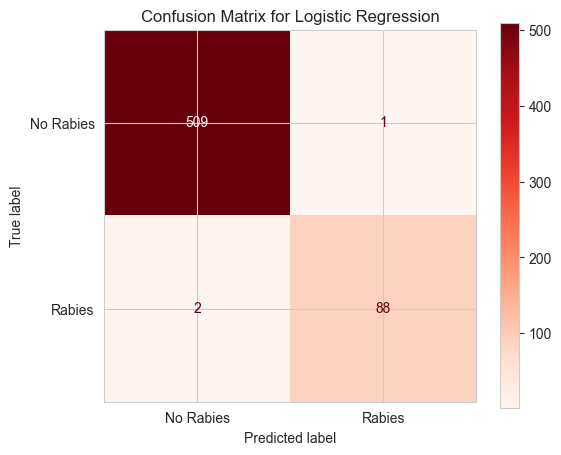

--- Evaluating: Random Forest ---
              precision    recall  f1-score   support

   No Rabies       1.00      1.00      1.00       510
      Rabies       0.99      0.98      0.98        90

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



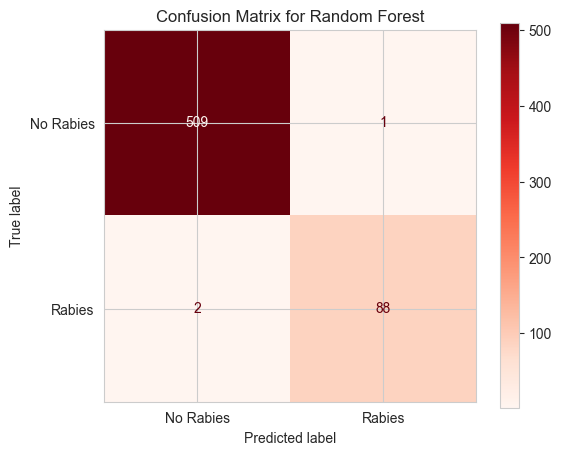

--- Evaluating: XGBoost ---
              precision    recall  f1-score   support

   No Rabies       1.00      1.00      1.00       510
      Rabies       0.99      0.98      0.98        90

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



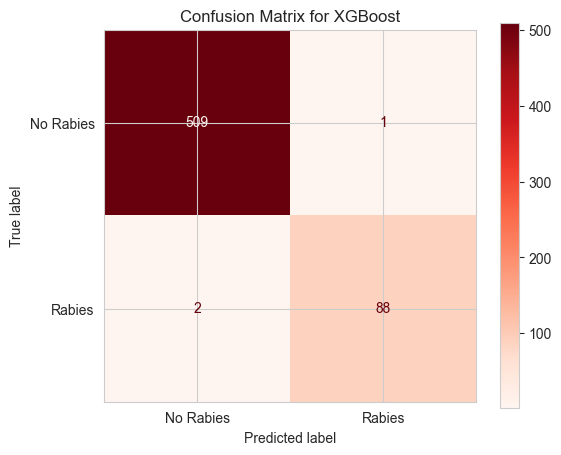

In [11]:
# Store results for comparison
results = {}

for name, model in models.items():
    print(f"--- Evaluating: {name} ---")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Define the target names once
    class_labels = ['No Rabies', 'Rabies']
    
    # Generate classification report for printing
    report = classification_report(y_test, y_pred, target_names=class_labels)
    print(report)
    
    # THE FIX: Add target_names to this call to create the dictionary with the correct keys.
    report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=class_labels)
    
    # Now this line will work correctly
    results[name] = report_dict['Rabies']['recall']
    
    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Use the same class_labels for the display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Reds')
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()

In [15]:
# Find the best model based on Recall for the 'Rabies' class
# best_model_name = max(results, key=results.get)
best_model_name = "XGBoost"
best_model_recall = results["XGBoost"]

print("\n--- Model Comparison (Based on Rabies Recall) ---")
for name, recall in results.items():
    print(f"{name}: {recall:.4f}")
    
print(f"\n🏆 The best performing model is: {best_model_name} with a Recall of {best_model_recall:.4f}")
print(f"\nThis means the {best_model_name} model correctly identified {best_model_recall:.2%} of all actual rabies cases in the test set.")

# You can now use the best model for future predictions
best_model = models[best_model_name]


--- Model Comparison (Based on Rabies Recall) ---
Logistic Regression: 0.9778
Random Forest: 0.9778
XGBoost: 0.9778

🏆 The best performing model is: XGBoost with a Recall of 0.9778

This means the XGBoost model correctly identified 97.78% of all actual rabies cases in the test set.


In [16]:
import pickle

# Select the best model from your dictionary
best_model_name = "XGBoost" 
best_model = models[best_model_name]

# Define a filename for your model
filename = 'xgboost_rabies_model.pkl'

# Open a file in write-binary mode and save the model to it
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model '{best_model_name}' has been saved successfully as '{filename}'")

Model 'XGBoost' has been saved successfully as 'xgboost_rabies_model.pkl'


In [1]:
import pickle
import pandas as pd
import numpy as np

# Load the saved model pipeline from the file
try:
    with open('xgboost_rabies_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    print("Model loaded successfully!")
except FileNotFoundError:
    print("Error: Model file not found. Make sure 'xgboost_rabies_model.pkl' is in the directory.")

Model loaded successfully!


In [14]:
def predict_rabies_risk(dog_data):
    """
    Predicts the risk of rabies for a single dog using the loaded model.
    
    Args:
        dog_data (dict): A dictionary containing the dog's features.
    
    Returns:
        tuple: A tuple containing the prediction string and the confidence probability.
    """
    # Define the correct order of columns that the model was trained on
    # This must match the order in the original DataFrame, excluding 'dog_id' , 'rabies', 'dog_age'.
    feature_order = ['vaccinated', 'grooming', 'fever', 'lethargy', 'behavior_change',
       'aggression', 'excessive_drooling', 'difficulty_swallowing', 'seizures',
       'staggering_gait', 'hind_leg_paralysis', 'jaw_dropped']
    
    # 1. Convert the input dictionary into a pandas DataFrame
    # The model's pipeline expects a DataFrame with the correct column names
    input_df = pd.DataFrame([dog_data]).applymap({'yes': 1, 'no': 0}.get)
    
    # # 2. Ensure the DataFrame columns are in the correct order
    # input_df = input_df[feature_order].map({'yes': 1, 'no': 0})

    # 3. Use the model to predict the class (0 or 1)
    prediction_code = loaded_model.predict(input_df)[0]
    
    # 4. Use the model to predict the probability for each class
    # predict_proba returns an array like [[prob_no, prob_yes]]
    prediction_proba = loaded_model.predict_proba(input_df)[0]
    
    # 5. Interpret the results into a human-readable format
    if prediction_code == 1:
        prediction_text = "High Risk: Rabies Detected"
        confidence = prediction_proba[1] # Probability of 'yes' (rabies)
    else:
        prediction_text = "Low Risk: No Rabies Detected"
        confidence = prediction_proba[0] # Probability of 'no'
        
    return prediction_text, confidence

In [39]:
# --- TEST SCENARIOS ---

# feature_order = ['vaccinated', 'grooming', 'fever', 'lethargy', 'behavior_change',
#        'aggression', 'excessive_drooling', 'difficulty_swallowing', 'seizures',
#        'staggering_gait', 'hind_leg_paralysis', 'jaw_dropped']

# Scenario 1: A clear high-risk case
high_risk_dog = {
    'vaccinated': 'yes',
    'grooming': 'no',
    'fever': 'no',
    'lethargy': 'yes',
    'behavior_change':'yes',
    'aggression': 'no',
    'excessive_drooling': 'no',
    'difficulty_swallowing': 'no',
    'seizures': 'no',
    'staggering_gait': 'no',
    'hind_leg_paralysis': 'no',
    'jaw_dropped': 'no'  
}


# Test Case 1
prediction, confidence = predict_rabies_risk(high_risk_dog)
print(f"\nTest Case 1 (High-Risk Dog):")
print(f"  Prediction: {prediction}")
print(f"  Confidence: {confidence:.2%}")



Test Case 1 (High-Risk Dog):
  Prediction: High Risk: Rabies Detected
  Confidence: 69.04%


C:\Users\ywcha\AppData\Local\Temp\ipykernel_22276\1441853873.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  input_df = pd.DataFrame([dog_data]).applymap({'yes': 1, 'no': 0}.get)
